# Model Building

In [1]:
# Import libraries
import pandas as pd
import boto3
import sagemaker
from pyathena import connect
from sagemaker.session import Session
from sagemaker.feature_store.feature_group import FeatureGroup
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from time import gmtime, strftime, sleep
from sagemaker.model import Model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# View created feature groups
!aws sagemaker list-feature-groups

{
    "FeatureGroupSummaries": [
        {
            "FeatureGroupName": "foodlens-products-feature-group-30-14-49-50",
            "FeatureGroupArn": "arn:aws:sagemaker:us-east-1:654654380268:feature-group/foodlens-products-feature-group-30-14-49-50",
            "CreationTime": "2025-09-30T14:49:51.125000+00:00",
            "FeatureGroupStatus": "Created",
            "OfflineStoreStatus": {
                "Status": "Active"
            }
        }
    ]
}


In [3]:
# Change this to your feature group (ex. "foodlens-products-feature-group-30-14-49-50")
feature_group_name = "foodlens-products-feature-group-30-14-49-50"
assert feature_group_name is not None

In [4]:
# Initialize SageMaker session and Feature Group
# Setup boto and sagemaker session
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
feature_group = FeatureGroup(name=feature_group_name, sagemaker_session=sess)
prefix = "nutriscore-prediction-xgboost"

# Initialize athena query staging
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

# Create connection to Athena database
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [6]:
# Describe feature group and get key attributes
record_id_name = feature_group.describe()['RecordIdentifierFeatureName']
table_name = feature_group.athena_query().table_name
print(f"Athena Table Name: {table_name}")
print(f"Record Identifier: {record_id_name}")

Athena Table Name: foodlens_products_feature_group_30_14_49_50_1759243791
Record Identifier: code


In [7]:
# Verify 100k unique records in feature store
statement = """SELECT COUNT(DISTINCT "code") 
FROM sagemaker_featurestore.{}""".format(table_name)
print(statement)
df = pd.read_sql(statement, conn)
df

SELECT COUNT(DISTINCT "code") 
FROM sagemaker_featurestore.foodlens_products_feature_group_30_14_49_50_1759243791


/tmp/ipykernel_625/3127886201.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


,_col0
0,100000


## Prepare Dataset Splits

In [8]:
# Split data into training/testing/validation/production sets

# Base query template
# We use xxhash64 for its speed. It creates a deterministic hash for each record ID.
query_template = f"""
SELECT *
FROM "{table_name}"
WHERE MOD(ABS(from_big_endian_64(xxhash64(CAST("{record_id_name}" AS VARBINARY)))), 100)
"""

# --- Training Data (40%) ---
train_query_string = query_template + " BETWEEN 0 AND 39"
train_query = feature_group.athena_query()
train_query.run(query_string=train_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/train/')
train_query.wait()
train_df = train_query.as_dataframe(dtype={0: str}) # code col as str

# --- Production Data (40%) ---
prod_query_string = query_template + " BETWEEN 40 AND 79"
prod_query = feature_group.athena_query()
prod_query.run(query_string=prod_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/prod/')
prod_query.wait()
prod_df = prod_query.as_dataframe()

# --- Test Data (10%) ---
test_query_string = query_template + " BETWEEN 80 AND 89"
test_query = feature_group.athena_query()
test_query.run(query_string=test_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/test/')
test_query.wait()
test_df = test_query.as_dataframe()

# --- Validation Data (10%) ---
validation_query_string = query_template + " BETWEEN 90 AND 99"
validation_query = feature_group.athena_query()
validation_query.run(query_string=validation_query_string, output_location=f'{s3_staging_dir}/feature_store_queries/validation/')
validation_query.wait()
val_df = validation_query.as_dataframe()

# Verify the shapes of the resulting DataFrames
print(f"Training set shape:   {train_df.shape}")
print(f"Production set shape: {prod_df.shape}")
print(f"Test set shape:       {test_df.shape}")
print(f"Validation set shape: {val_df.shape}")

Training set shape:   (39955, 30)
Production set shape: (39992, 30)
Test set shape:       (9962, 30)
Validation set shape: (10091, 30)


In [9]:
# View training data samples
pd.set_option('display.max_columns', None)
train_df.head(3)

,code,product_name,nova_group,additives_n,ingredients_n,nutriscore_score,energy_100g,salt_100g,carbohydrates_100g,cholesterol_100g,sodium_100g,fiber_100g,fruits_vegetables_legumes_estimate_from_ingredients_100g,sugars_100g,saturated_fat_100g,trans_fat_100g,fat_100g,proteins_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g,energy_kcal_100g,nova_group_100g,nutrition_score_fr_100g,vitamin_a_100g,iron_100g,calcium_100g,vitamin_c_100g,eventtime,write_time,api_invocation_time,is_deleted
0,0855230002139,Mother In Laws Gochujang,3,0,5,27,855.0,4.550,40.90,0.0,1.820,2.27,0.000000,18.20,0.0,0.0,2.27,9.09,0.000000,205.0,3.0,27.0,0.000000,0.00071,0.0254,0.0000,1.759244e+09,2025-09-30 14:57:53.991,2025-09-30 14:52:54.000,False
1,0046569504160,Chicago green relish,4,5,16,14,464.0,1.340,28.57,0.0,0.536,0.90,53.333332,28.57,0.0,0.0,0.00,0.00,53.333332,111.0,4.0,14.0,0.000054,0.00071,0.0000,0.0000,1.759244e+09,2025-09-30 14:57:53.991,2025-09-30 14:52:54.000,False
2,0623237000201,6 Kaiser Buns,3,0,8,7,1004.0,1.485,48.00,0.0,0.594,1.60,0.000000,0.00,0.4,0.0,1.20,7.00,0.000000,240.0,3.0,7.0,0.000000,0.00252,0.0000,0.0048,1.759244e+09,2025-09-30 14:57:53.991,2025-09-30 14:52:54.000,False


## Data Preprocessing

In [10]:
# Feature selection
target = 'nutriscore_score'
cols_to_drop = [
    target,
    'code',
    'product_name',
    'nutrition_score_fr_100g', # data leakage
    'eventtime',
    'write_time',
    'api_invocation_time',
    'is_deleted']

# Set training data
y_train = train_df[target]
X_train = train_df.drop(columns=cols_to_drop)

# Set testing data
y_test = test_df[target]
X_test = test_df.drop(columns=cols_to_drop)

# Set validation data
y_val = val_df[target]
X_val = val_df.drop(columns=cols_to_drop)

# Set production data
y_prod = prod_df[target]
X_prod = prod_df.drop(columns=cols_to_drop)

# View filtered training data
X_train.head()

,nova_group,additives_n,ingredients_n,energy_100g,salt_100g,carbohydrates_100g,cholesterol_100g,sodium_100g,fiber_100g,fruits_vegetables_legumes_estimate_from_ingredients_100g,sugars_100g,saturated_fat_100g,trans_fat_100g,fat_100g,proteins_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g,energy_kcal_100g,nova_group_100g,vitamin_a_100g,iron_100g,calcium_100g,vitamin_c_100g
0,3,0,5,855.0,4.5500,40.90,0.0,1.82000,2.27,0.000000,18.20,0.00,0.0,2.27,9.09,0.000000,205.00,3.0,0.000000,0.00071,0.0254,0.0000
1,4,5,16,464.0,1.3400,28.57,0.0,0.53600,0.90,53.333332,28.57,0.00,0.0,0.00,0.00,53.333332,111.00,4.0,0.000054,0.00071,0.0000,0.0000
2,3,0,8,1004.0,1.4850,48.00,0.0,0.59400,1.60,0.000000,0.00,0.40,0.0,1.20,7.00,0.000000,240.00,3.0,0.000000,0.00252,0.0000,0.0048
3,4,9,47,953.0,2.0904,25.32,0.0,0.83616,1.27,25.195312,1.27,2.53,0.0,12.66,3.80,25.195312,227.85,4.0,0.000000,0.00137,0.0000,0.0000
4,4,10,36,1460.0,2.0925,41.86,0.0,0.83700,0.00,0.000000,9.30,4.65,0.0,16.28,4.65,0.110449,349.00,4.0,0.000000,0.00251,0.0000,0.0000


In [11]:
# Perform Standardization scaling for regression (FIT ONLY ON TRAINING DATA)

# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Fit the pipeline on the training data
X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)
X_val_scaled = preprocessing_pipeline.transform(X_val)
X_prod_scaled = preprocessing_pipeline.transform(X_prod)

# View scaled training data samples
print(X_train_scaled[:3])

[[-4.52933330e-01 -7.66744498e-01 -7.38871574e-01 -2.34179390e-01
   4.49291343e-02  7.90073677e-06 -3.27685280e-02  4.49118970e-02
  -8.00192973e-02 -5.52117005e-01 -2.45116485e-02 -3.97483948e-01
  -3.76331319e-02 -3.62410303e-01  8.35783312e-03 -6.58564173e-01
  -2.33264776e-01 -4.52933330e-01 -5.93821880e-03 -2.05829844e-02
  -1.25518332e-01 -7.85495195e-02]
 [ 5.80941853e-01  7.17666608e-01 -1.03370735e-01 -3.96924020e-01
  -1.73574964e-02 -1.52395447e-01 -3.27685280e-02 -1.73558975e-02
  -2.21161478e-01  1.29131619e+00  1.65585850e-01 -3.97483948e-01
  -3.76331319e-02 -4.22133347e-01 -2.95641969e-01  9.90677528e-01
  -3.96949285e-01  5.80941853e-01 -5.93577239e-03 -2.05829844e-02
  -1.92636624e-01 -7.85495195e-02]
 [-4.52933330e-01 -7.66744498e-01 -5.65553164e-01 -1.72161615e-01
  -1.45439258e-02  8.77665197e-02 -3.27685280e-02 -1.45431778e-02
  -1.49045035e-01 -5.52117005e-01 -3.58144674e-01 -3.68631450e-01
  -3.76331319e-02 -3.90561693e-01 -6.15387110e-02 -6.58564173e-01
  -1.7

In [12]:
# Prepare data splits for upload
# Convert scaled splits back into dataframe.
# We also need to set the target as the first column.
# This is required by the SageMaker XGBoost algorithm.

X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
train_upload_df = pd.concat([pd.DataFrame(y_train).reset_index(drop=True), X_train_df], axis=1)

X_test_df = pd.DataFrame(X_test_scaled)
test_upload_df = pd.concat([pd.DataFrame(y_test).reset_index(drop=True), X_test_df], axis=1)

X_val_df = pd.DataFrame(X_val_scaled)
val_upload_df = pd.concat([pd.DataFrame(y_val).reset_index(drop=True), X_val_df], axis=1)

X_prod_df = pd.DataFrame(X_prod_scaled)
prod_upload_df = pd.concat([pd.DataFrame(y_prod).reset_index(drop=True), X_prod_df], axis=1)

# View scaled training data samples
train_upload_df.head()

,nutriscore_score,nova_group,additives_n,ingredients_n,energy_100g,salt_100g,carbohydrates_100g,cholesterol_100g,sodium_100g,fiber_100g,fruits_vegetables_legumes_estimate_from_ingredients_100g,sugars_100g,saturated_fat_100g,trans_fat_100g,fat_100g,proteins_100g,fruits_vegetables_nuts_estimate_from_ingredients_100g,energy_kcal_100g,nova_group_100g,vitamin_a_100g,iron_100g,calcium_100g,vitamin_c_100g
0,27,-0.452933,-0.766744,-0.738872,-0.234179,0.044929,0.000008,-0.032769,0.044912,-0.080019,-0.552117,-0.024512,-0.397484,-0.037633,-0.362410,0.008358,-0.658564,-0.233265,-0.452933,-0.005938,-0.020583,-0.125518,-0.078550
1,14,0.580942,0.717667,-0.103371,-0.396924,-0.017357,-0.152395,-0.032769,-0.017356,-0.221161,1.291316,0.165586,-0.397484,-0.037633,-0.422133,-0.295642,0.990678,-0.396949,0.580942,-0.005936,-0.020583,-0.192637,-0.078550
2,7,-0.452933,-0.766744,-0.565553,-0.172162,-0.014544,0.087767,-0.032769,-0.014543,-0.149045,-0.552117,-0.358145,-0.368631,-0.037633,-0.390562,-0.061539,-0.658564,-0.172318,-0.452933,-0.005938,0.005732,-0.192637,0.002666
3,14,0.580942,1.905195,1.687586,-0.193389,-0.002797,-0.192567,-0.032769,-0.002800,-0.183043,0.318743,-0.334864,-0.214992,-0.037633,-0.089052,-0.168557,0.120558,-0.193476,0.580942,-0.005938,-0.010987,-0.192637,-0.078550
4,20,0.580942,2.202078,1.052085,0.017638,-0.002756,0.011874,-0.032769,-0.002759,-0.313883,-0.552117,-0.187662,-0.062074,-0.037633,0.006189,-0.140131,-0.655149,0.017486,0.580942,-0.005938,0.005587,-0.192637,-0.078550


In [13]:
# Upload train data with headers for data monitor
train_file_headers = "train_scaled_headers_features_only.csv"
train_upload_headers_features_only_df = test_upload_df.drop(columns=[target])
train_upload_headers_features_only_df.to_csv(train_file_headers, index=False, header=True)
train_s3_path = sess.upload_data(train_file_headers, key_prefix="{}/train".format(prefix))
print(f"Train data with headers uploaded to: {train_s3_path}")

Train data with headers uploaded to: s3://sagemaker-us-east-1-654654380268/nutriscore-prediction-xgboost/train/train_scaled_headers_features_only.csv


In [14]:
# Upload data files to S3
train_file = "train_scaled.csv"
train_upload_df.to_csv(train_file, index=False, header=False)
train_s3_path = sess.upload_data(train_file, key_prefix="{}/train".format(prefix))
print(f"Train data uploaded to: {train_s3_path}")

test_file = "test_scaled.csv"
test_upload_df.to_csv(test_file, index=False, header=False)
test_s3_path = sess.upload_data(test_file, key_prefix="{}/test".format(prefix))
print(f"Test data uploaded to: {test_s3_path}")

# Upload test file without target col for batch transform later
test_features_only_file = "test_features_only.csv"
test_features_only_df = test_upload_df.drop(columns=[target])
test_features_only_df.to_csv(test_features_only_file, index=False, header=False)
test_features_only_s3_path = sess.upload_data(test_features_only_file, key_prefix="{}/test".format(prefix))
print(f"Test data for batch transform uploaded to: {test_features_only_s3_path}")

val_file = "val_scaled.csv"
val_upload_df.to_csv(val_file, index=False, header=False)
val_s3_path = sess.upload_data(val_file, key_prefix="{}/validation".format(prefix))
print(f"Val data uploaded to: {val_s3_path}")

prod_file = "prod_scaled.csv"
prod_upload_df.to_csv(prod_file, index=False, header=False)
prod_s3_path = sess.upload_data(prod_file, key_prefix="{}/prod".format(prefix))
print(f"Prod data uploaded to: {prod_s3_path}")

Train data uploaded to: s3://sagemaker-us-east-1-654654380268/nutriscore-prediction-xgboost/train/train_scaled.csv
Test data uploaded to: s3://sagemaker-us-east-1-654654380268/nutriscore-prediction-xgboost/test/test_scaled.csv
Test data for batch transform uploaded to: s3://sagemaker-us-east-1-654654380268/nutriscore-prediction-xgboost/test/test_features_only.csv
Val data uploaded to: s3://sagemaker-us-east-1-654654380268/nutriscore-prediction-xgboost/validation/val_scaled.csv
Prod data uploaded to: s3://sagemaker-us-east-1-654654380268/nutriscore-prediction-xgboost/prod/prod_scaled.csv


## Baseline: Training Job and Model Creation

=== Linear Regression Baseline Performance ===
Test Set:       RMSE = 8.194, MAE = 6.414, R² = 0.380

Sample Predictions:
   Actual  Predicted
0      23  16.316431
1      10  14.637900
2      18  17.372914
3       8  12.892399
4      18  10.131048
5      23  15.133069
6      19  10.754080
7      37  13.646268
8      10  14.033839
9      15  14.618195


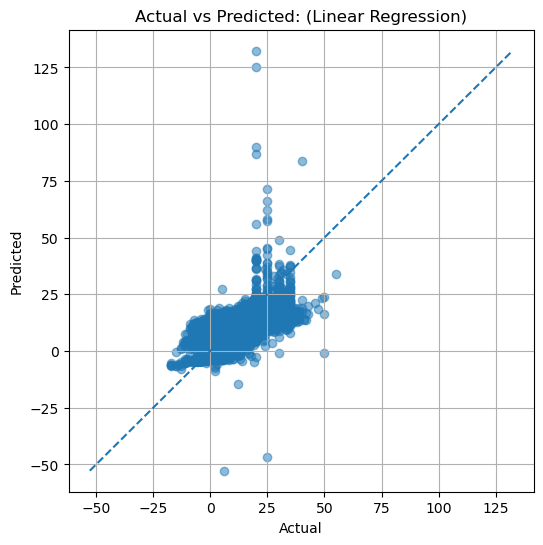

In [15]:
# Baseline Model: Linear Regression
y_train = np.asarray(y_train).ravel()
y_test = np.asarray(y_test).ravel()

baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

y_pred_test = baseline_model.predict(X_test_scaled)

mse_test_baseline = mean_squared_error(y_test, y_pred_test)
rmse_test_baseline = np.sqrt(mse_test_baseline)
mae_test_baseline = mean_absolute_error(y_test, y_pred_test)
r2_test_baseline = r2_score(y_test, y_pred_test)

# Print results
print("=== Linear Regression Baseline Performance ===")
print(f"Test Set: RMSE = {rmse_test_baseline:.3f}, MAE = {mae_test_baseline:.3f}, R² = {r2_test_baseline:.3f}")

# Sample predictions
comparison_df = pd.DataFrame({
    "Actual": y_test[:10],
    "Predicted": y_pred_test[:10]
})
print("\nSample Predictions:")
print(comparison_df)

# Actual vs Predicted scatter plot for test set
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
maxv = max(np.max(y_test), np.max(y_pred_test))
minv = min(np.min(y_test), np.min(y_pred_test))
plt.plot([minv, maxv], [minv, maxv], linestyle='--') 
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted: (Linear Regression)")
plt.grid(True)
plt.show()

## XGBoost: Training Job and Model Creation

In [16]:
# Create training job
job_name = "nutrition-score-xgb-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
output_location = f"s3://{bucket}/{prefix}/output/{job_name}"

# Specify model
image = sagemaker.image_uris.retrieve(framework="xgboost", region=region, version="1.7-1")
instance_type = 'ml.m5.xlarge'
model_name = job_name

# Set estimator
sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=1,
    instance_type=instance_type,
    output_path=output_location,
    sagemaker_session=sess,
)

# Set hyperparameters for regression
sm_estimator.set_hyperparameters(
    objective="reg:squarederror",
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    num_round=100,
)

# Set input locations for train and val sets
train_data = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/train", content_type="text/csv"
)
val_data = sagemaker.inputs.TrainingInput(
    f"s3://{bucket}/{prefix}/validation", content_type="text/csv"
)
data_channels = {"train": train_data, "validation": val_data}

# Launch training job
sm_estimator.fit(inputs=data_channels, job_name=job_name, logs=False)

INFO:sagemaker:Creating training-job with name: nutrition-score-xgb-2025-10-20-00-17-20



2025-10-20 00:17:22 Starting - Starting the training job..
2025-10-20 00:17:37 Starting - Preparing the instances for training..
2025-10-20 00:17:55 Downloading - Downloading input data....
2025-10-20 00:18:20 Downloading - Downloading the training image.........
2025-10-20 00:19:11 Training - Training image download completed. Training in progress.....
2025-10-20 00:19:37 Uploading - Uploading generated training model..
2025-10-20 00:19:50 Completed - Training job completed


## Batch Transform Job for Test Predictions

In [17]:
# Create transformer object from trained estimator
transformer = sm_estimator.transformer(
    instance_count=1,
    instance_type=instance_type
)

# Start the batch transform job
transformer.transform(
    data=test_features_only_s3_path,
    content_type='text/csv',
    logs=False,
    wait=True
)

# Wait for the job to complete
print("Job complete.")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-10-20-00-19-52-986
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2025-10-20-00-19-53-762


...................................................................!
Job complete.


## Compare Model Performance

In [18]:
# Calculate performance on test set

# S3 location of the prediction results
output_s3_path = transformer.output_path

# Download the prediction results into a pandas DataFrame
predictions_df = pd.read_csv(f"{output_s3_path}/{test_features_only_file}.out", header=None)
predictions_df

,0
0,24.254988
1,12.183371
2,17.819515
3,7.036993
4,18.793779
...,...
9957,11.910203
9958,1.015789
9959,19.233126
9960,24.672974


In [19]:
# Calculate performance metrics
predictions = predictions_df[0]
rmse_test_xgb = mean_squared_error(y_test, predictions)
mae_test_xgb = mean_absolute_error(y_test, predictions)
r2_test_xgb = r2_score(y_test, predictions)

print(f"XGBoost Model Performance:")
print(f"RMSE: {rmse_test_xgb}")
print(f"MAE:  {mae_test_xgb}")
print(f"R²:   {r2_test_xgb}")

XGBoost Model Performance:
RMSE: 3.448158144203241
MAE:  1.0999017302031018
R²:   0.9681759462770739


In [20]:
# Compare Baseline (Linear Regression) vs XGBoost Model

print("Model Comparison: Linear Regression vs XGBoost:")

# Create comparison df
data = {
    "RMSE": [rmse_test_baseline, rmse_test_xgb],
    "MAE": [mae_test_baseline, mae_test_xgb],
    "R²": [r2_test_baseline, r2_test_xgb]
}

# Improvement Summary
rmse_improvement = rmse_test_baseline - rmse_test_xgb
r2_improvement = (r2_test_xgb - r2_test_baseline) / r2_test_baseline * 100 if r2_test_baseline != 0 else float('inf')

print(f"XGBoost reduced RMSE by {rmse_improvement:.3f} points compared to baseline.")
print(f"XGBoost improved R² by {r2_improvement:.1f}% over Linear Regression.\n")

comparison_df = pd.DataFrame(data, index=["Linear Regression (Baseline)", "XGBoost"])
comparison_df

Model Comparison: Linear Regression vs XGBoost:
XGBoost reduced RMSE by 4.746 points compared to baseline.
XGBoost improved R² by 154.5% over Linear Regression.



,RMSE,MAE,R²
Linear Regression (Baseline),8.193790,6.413762,0.380362
XGBoost,3.448158,1.099902,0.968176


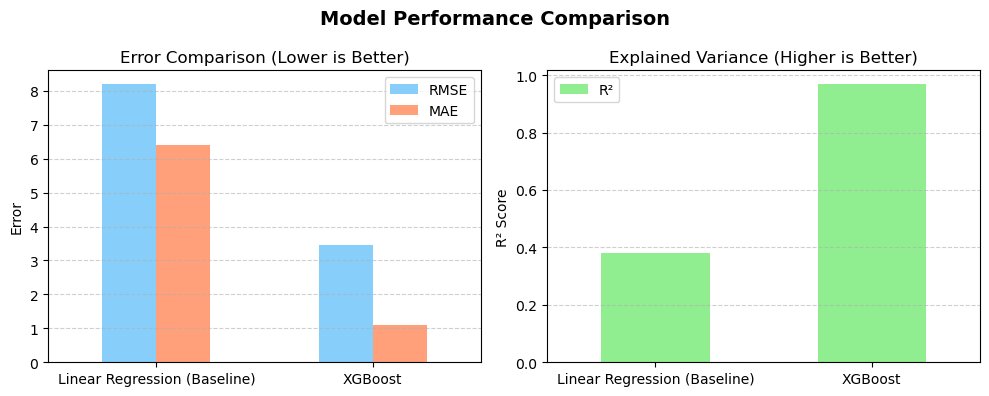

In [21]:
# Plot RMSE and MAE 
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

comparison_df[["RMSE", "MAE"]].plot(kind="bar", ax=axes[0], rot=0, color=["#87CEFA", "#FFA07A"])
axes[0].set_title("Error Comparison (Lower is Better)")
axes[0].set_ylabel("Error")
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

#  Plot R² 
comparison_df[["R²"]].plot(kind="bar", ax=axes[1], rot=0, color=["#90EE90"])
axes[1].set_title("Explained Variance (Higher is Better)")
axes[1].set_ylabel("R² Score")
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.suptitle("Model Performance Comparison", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

Nutritional and ingredient-based features in the dataset interact in complex, non-linear ways that are better captured by tree-based methods. The baseline linear model could only approximate broad linear relationships between features (e.g., energy or sugar content) and NutriScore, whereas XGBoost effectively modeled higher-order dependencies—such as how combinations of fats, sugars, and additives jointly influence nutritional quality.

## Upload Trained XGBoost Model to SageMaker Model Registry

In [22]:
# Initialize the sagemaker client
sagemaker_client = boto3.client("sagemaker")

# Get the S3 path to the trained model artifacts
info = sagemaker_client.describe_training_job(TrainingJobName=job_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Model artifacts are located at: {model_data}")

# Define the container image for inference (we defined 'image' earlier)
primary_container = {"Image": image, "ModelDataUrl": model_data}

# Save model to Sagemaker Model Registry
create_model_response = sagemaker_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer=primary_container
)

print(f"\nSuccessfully created model: {create_model_response['ModelArn']}")

Model artifacts are located at: s3://sagemaker-us-east-1-654654380268/nutriscore-prediction-xgboost/output/nutrition-score-xgb-2025-10-20-00-17-20/nutrition-score-xgb-2025-10-20-00-17-20/output/model.tar.gz

Successfully created model: arn:aws:sagemaker:us-east-1:654654380268:model/nutrition-score-xgb-2025-10-20-00-17-20


In [23]:
%store model_name
model_name

Stored 'model_name' (str)


'nutrition-score-xgb-2025-10-20-00-17-20'

## Live Endpoint Invocation Example

In [ ]:
# Create Endpoint Configuration
endpoint_config_name = f"xgb-nutriscore-config-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
print(f"Creating endpoint configuration: {endpoint_config_name}")

# Create the endpoint configuration
endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": instance_type,
            "InitialInstanceCount": 1
        }
    ]
)
print(f"Created EndpointConfig: {endpoint_config_response['EndpointConfigArn']}")

In [ ]:
# Create real-time endpoint
endpoint_name = f"xgb-nutriscore-endpoint-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
print(f"Creating endpoint: {endpoint_name}")

# Create the endpoint
create_endpoint_response = sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)
print(f"Created Endpoint: {create_endpoint_response['EndpointArn']}")

# Wait for endpoint to spin up
sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
print("Waiting for endpoint to be in service...")

while True:
    res = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    state = res["EndpointStatus"]
    
    if state == "InService":
        print("Endpoint in Service")
        break
    elif state == "Creating":
        print("Endpoint still creating...")
        sleep(60)
    else:
        print("Endpoint Creation Error - Check Sagemaker Console")
        break

In [ ]:
# Initialize runtime client
sagemaker_runtime = boto3.client("sagemaker-runtime", region_name=region)

# Prepare test sample
sample_record = X_test.iloc[[0]]
sample_target = y_test[0]

# Scale sample
sample_scaled = preprocessing_pipeline.transform(sample_record)

# Convert scaled sample into csv string
payload = ','.join([str(x) for x in sample_scaled[0]])
print(f"Sending payload: {payload}")

In [ ]:
# Invoke the Endpoint
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='text/csv',
    Body=payload
)

# Examine the response to see the prediction
prediction = response['Body'].read().decode('utf-8')
print(f"\nSample Target: {sample_target}")
print(f"Received prediction (nutriscore_score): {prediction}")

In [ ]:
# Delete endpoint to save resources
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)